# Introduction

Project: **The Purrposterous Daily**

**Data Collection**: Connect to the Reddit API and fetch the most recent or 'hot' posts from selected subreddits. The data collected would include features such as the post title, content, upvotes, number of comments, and the time it was posted. Why Reddit? Because it's one of the rare places where topics are discussed among humans (so far) that sometimes haven't reached the mainstream media yet. It's also a place where people are more likely to be honest about their opinions, and where the most popular opinions are upvoted to the top. This makes it a great place to find out what's trending and what's important to people.


**Data Processing and ML Model**: The data is processed and transformed into a form suitable for ML modeling. The ML model is trained to classify posts based on these features. For instance, it could classify posts as 'trending', 'important', 'interesting', etc., based on their characteristics.

Integration with ChatGPT: Once the ML model has classified the posts, ChatGPT is used to generate a summary or recap of the findings. This text is generated in a way that is catchy and meme-friendly. Additionally, GPT also generates a set of relevant hashtags based on the content of the meme.

Meme Generation: The text generated by GPT is then used as a prompt for Midgeourney (or another AI image generator), which creates a meme based on the text.

Posting to Instagram: The generated meme along with the hashtags is then posted to Instagram. Instagram's API could be used for automating the posting process.

# Gather data

In [1]:
import pandas as pd

In [244]:
import praw

def get_credentials(filename):
    credentials = {}
    with open(filename, 'r') as f:
        for line in f:
            key, value = line.strip().split('=')
            credentials[key] = value.replace('"', '')  
    return credentials

credentials = get_credentials('cred.txt')

reddit = praw.Reddit(
    client_id=credentials["REDDIT_CLIENT_ID"],
    client_secret=credentials["REDDIT_SECRET"],
    user_agent="my_user_agent"
)


hot_posts = reddit.subreddit('nottheonion').hot(limit=1000)
data = []

for post in hot_posts:
    data.append({
        "title": post.title,
        "score": post.score,
        "id": post.id,
        "url": post.url,
        "created": post.created,
        "body": post.selftext,
        "comments": post.num_comments,
        "upvote_ratio": post.upvote_ratio,
        "length_title": len(post.title),
        "length_body": len(post.selftext),
        "is_stickied": post.stickied,
        "is_original_content": post.is_original_content,
        "total_awards_received": post.total_awards_received
    })
    
df = pd.DataFrame(data)

In [249]:
df

,title,score,id,url,created,body,comments,upvote_ratio,length_title,length_body,is_stickied,is_original_content,total_awards_received
0,"NAACP issues travel advisory for Florida, saying the state is 'openly hostile toward African Americans' under Gov. DeSantis' administration",3204,13oo9ug,https://www.cnn.com/2023/05/21/us/naacp-florida-travel-advisory/index.html,1.684755e+09,,315,0.93,139,0,False,False,0
1,New Zealand's ratio of sheep to people drops below five to one for first time in 170 years.,8506,13ofj8c,https://www.rnz.co.nz/news/country/490413/ratio-of-sheep-to-people-drops-below-five-to-one-for-first-time-in-170-years,1.684727e+09,,149,0.97,91,0,False,False,0
2,"Father killed, 2 teenage sons injured after a grenade exploded in an Indiana home",1506,13ojjyf,https://www.cnn.com/2023/05/21/us/grenade-explosion-kills-indiana-father/index.html,1.684740e+09,,214,0.95,81,0,False,False,0
3,"Maryland guardian arrives in stolen vehicle to take custody of teens arrested for auto theft, police say",422,13opbv5,https://www.foxnews.com/us/maryland-guardian-arrives-stolen-vehicle-take-custody-teens-arrested-auto-theft-police-say,1.684758e+09,,26,0.98,104,0,False,False,0
4,Mississippi transgender teen will miss high school graduation after being told to dress like a boy,144,13oohau,https://www.usatoday.com/story/news/nation/2023/05/20/transgender-teen-blocked-from-wearing-dress-mississippi-graduation/70239417007/,1.684756e+09,,46,0.80,98,0,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,You've got to 'bee' kidding me: Flight delayed after bees swarm wingtip,15,138jx5x,https://krcrtv.com/news/offbeat/youve-got-to-bee-kidding-me-delta-flight-delayed-after-bees-swarm-wingtip-houston-airport-delta-air-lines-beekeeper-pest-control-tennessee-department-of-agriculture,1.683289e+09,,0,0.71,71,0,False,False,0
394,Dog owner regrets not getting pet insurance after her pet eats human poop laced with meth,6,138ugtj,https://vancouver.citynews.ca/2023/05/04/vancouver-dog-insurance-meth/,1.683305e+09,,8,0.56,89,0,False,False,0
395,A Michigan school district has banned students from carrying backpacks,41,138c1d3,https://www.npr.org/2023/05/04/1173918607/flint-school-district-backpack-ban,1.683265e+09,"“…we have seen an increase in threatening behavior and contraband, including weapons, being brought into schools at all levels,"" the district said. ‘Backpacks make it easier for students to hide weapons, which can be disassembled and harder to identify or hidden in pockets, inside books or under other items.’”",23,0.83,70,311,False,False,0
396,"‘Just came out of the woods,’ says woman chased by 2 emus on rail trail",40,138a3o2,https://www.mlive.com/news/saginaw-bay-city/2023/05/just-came-out-of-the-woods-says-woman-chased-by-2-emus-on-rail-trail.html,1.683259e+09,,12,0.88,71,0,False,False,0


In [250]:
# make 'created' into a data format 
df['created'] = pd.to_datetime(df['created'], unit='s')

In [251]:
# save to csv
df.to_csv('data/df.csv', index=False)

In [2]:
# open df from csv
df = pd.read_csv("data/df.csv")

So Reddit already has a scoring system of sorts, thanks to the upvotes and 'hotness'. 

# Explore data

In [3]:
# pandas profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
profile.to_widgets()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Thanks to this quick EDA report, we can see most of the key takeaways. However for our analysis, we won't transform any of the data.  

# Classifcation models

I want to classify the reddit posts so that I can have an organised Instagram account. It will also allow me to do some basic filtering on the topics I do not want to share. 

## Unsupervised machine learning with clustering

After researching, in order to find clusters in this use case, I could be using Word2Vec (or Doc2Vec) and maybe LDA (Latent Dirichlet Allocation). There are no named clusters but instead we interpret the words associated. 

However, newer models such as BERT have been found to be more effective in NLP tasks like this, so I'll go straight for this approach.

In [ ]:
# First we need to generate embeddings (vectors) for each title

import torch
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

df['embedding'] = df['title'].apply(get_embedding)

In [110]:
# This step in needed to convert these 3D embeddings to 2D by taking the mean across the tokens for each title.

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    return embeddings

df['embedding'] = df['title'].apply(get_embedding)

In [111]:
# Now we can use UMAP to reduce the dimensionality of the embeddings to 2D

import umap.umap_ as umap

reducer = umap.UMAP(n_components=3, random_state=42)
embeddings_3d = reducer.fit_transform(np.vstack(df['embedding'].values))

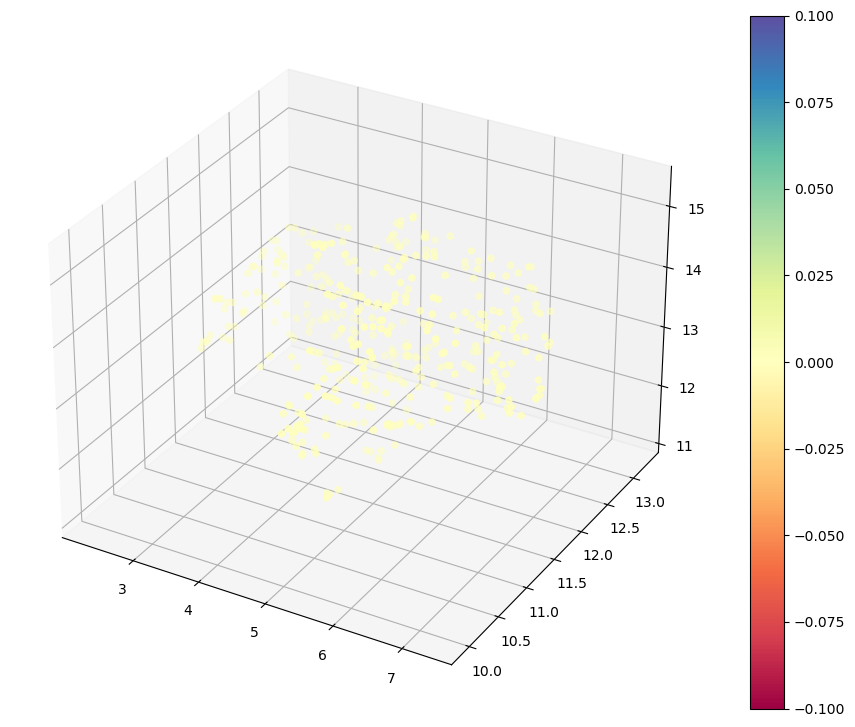

In [112]:
# DBSCAN is then used for the clustering 

from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=3, min_samples=2).fit(embeddings_3d)
df['cluster'] = clustering.labels_

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# 4. Visualization
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=df['cluster'], cmap='Spectral')
plt.colorbar(scatter)
plt.show()

In [114]:
# Let's render this in a plotly 3D scatter plot so we can interact with it

df['x'] = embeddings_3d[:, 0]
df['y'] = embeddings_3d[:, 1]
df['z'] = embeddings_3d[:, 2]

import plotly.graph_objects as go

data = []
for cluster_id in df['cluster'].unique():
    cluster_df = df[df['cluster'] == cluster_id]
    trace = go.Scatter3d(
        x=cluster_df['x'],
        y=cluster_df['y'],
        z=cluster_df['z'],
        mode='markers',
        text=cluster_df['title'],
        name=f"Cluster {cluster_id}",
        hoverinfo='text',
        marker=dict(
            size=5,
            opacity=0.8,
        )
    )
    data.append(trace)

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    legend=dict(
        itemsizing='constant'  
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()


The clustering is useless, just one big blob of data. I cannot extrapolate any topics here

## Supervised machine learning with labelling 

As unsupervised classification didn't prove to be of any use (small data sample anyway), let's try with a supervised learning approach.

So we want to be classifying the new posts in predefined categories. We need to label the data. We will be using the following categories: Environement, Education, Tech, Lifestyle, Culture, Economy, Politics, Science, Sports. 

In [166]:
# This is data that I labeled manually to each category 

labels = pd.read_csv('data/labels.csv')
labels.to_parquet('data/labels.parquet', index=False) 
labels = pd.read_parquet('data/labels.parquet')
labels

,Title,Cat1
0,Los Angeles Dodgers remove gay 'nun' group from Pride Night,Sports
1,Michigan boy who used slingshot to save sister says he 'was just lucky',Lifestyle
2,IT worker sues her boss believing 'xx' in email were kisses,Tech
3,Bouncy castle king jailed for burning down rivals,Lifestyle
4,Queen Elizabeth II's funeral cost UK government $200 million,Politics
...,...,...
387,"Australia's wildfires: Climate change to blame, scientists say",Environment
388,French President Macron tests positive for COVID-19,Politics
389,Massive coral reef taller than the Empire State Building found in Great Barrier Reef,Science
390,Wonder Woman 1984' breaks pandemic box office records,Culture


In [167]:
# renaming Title to title 
labels = labels.rename(columns={'Title': 'title'})

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch

data = df.merge(labels, on='title')

# encoding the labels
le = LabelEncoder()
data['labels'] = le.fit_transform(data['Cat1'])

# Split the data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(data['title'].tolist(), data['labels'].tolist(), test_size=.2, stratify=data['labels'].tolist())


class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        return {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
max_len = 200
batch_size = 16

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# DataLoaders
train_data = NewsDataset(train_texts, train_labels, tokenizer, max_len)
train_loader = DataLoader(train_data, batch_size=batch_size)

test_data = NewsDataset(test_texts, test_labels, tokenizer, max_len)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = len(le.classes_), 
    output_attentions = False, 
    output_hidden_states = False, 
)

In [130]:
# CPU if GPU isn't available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training parameters
epochs = 4
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

# Checkpoint path
checkpoint_path = 'bert-checkpoint.pth'

# The training loop
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    print('Average training loss: {0:.2f}'.format(avg_train_loss))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\user\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



Average training loss: 2.12
Average training loss: 1.86
Average training loss: 1.62
Average training loss: 1.50


In [132]:
def predict_category(title, model):
    encoding = tokenizer.encode_plus(
        title,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    output = model(input_ids=input_ids, attention_mask=attention_mask)
    _, prediction = torch.max(output[0], dim=1)
    return le.inverse_transform([prediction.item()])

# Use the model for prediction
title = "Biden gets reelected as president of the United States"
print(predict_category(title, model))

['Tech']


The categorisation is not the best, I'll test other parameters 

In [153]:
# CPU if GPU isn't available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training parameters
epochs = 6  # Increase the number of epochs
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # Decrease the learning rate
batch_size = 32  # Increase the batch size

# DataLoaders 
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Checkpoint path
checkpoint_path = 'bert-checkpoint2.pth'

# The training loop
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    print('Average training loss: {0:.2f}'.format(avg_train_loss))

def predict_category(title, model):
    encoding = tokenizer.encode_plus(
        title,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    output = model(input_ids=input_ids, attention_mask=attention_mask)
    _, prediction = torch.max(output[0], dim=1)
    return le.inverse_transform([prediction.item()])

# Use the model for prediction
title = "Biden gets reelected as president of the United States"
print(predict_category(title, model))


Average training loss: 1.44
Average training loss: 1.37
Average training loss: 1.34
Average training loss: 1.32
Average training loss: 1.29
Average training loss: 1.26
['Tech']


The results are not much better even after fine-tuning the parameters. On top of that, we could be overfitting the model.

## Zero-shot 

The type of classification I want to to is quite common, NEWS, I'll explore what models already exist 

https://huggingface.co/Yueh-Huan/news-category-classification-distilbert

After browsing, this pretrained model seems to do a very good job! 

It's based on the dataset found here: https://www.kaggle.com/datasets/rmisra/news-category-dataset

In [236]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "Yueh-Huan/news-category-classification-distilbert"

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Model in TensorFlow format
model = AutoModelForSequenceClassification.from_pretrained(model_name, from_tf=True)

text = "Fishing cheats net prison sentence over scandal"
inputs = tokenizer(text, return_tensors="pt")

logits = model(**inputs).logits
probabilities = torch.nn.functional.softmax(logits, dim=-1)
predicted_class = torch.argmax(probabilities)

print(f"Predicted class: {predicted_class.item()}")

All TF 2.0 model weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


Predicted class: 27


In [234]:
# the indices of the labels are not public, so I'll manually test sentences and deduce the mapping 

label_dict = {
    'Parents': 0,
    'Wellness': 1,
    'Comedy': 3,
    'Parenting': 2,
    'Politics': 4,
    'Black Voices': 5,
    'Queer Voices': 6,
    'Entertainment': 7,
    'Culture & Arts': 8,
    'Tech': 9,
    'Religion': 10, 
    'Style & Beauty': 11, 
    'Healthy living': 12,
    'Travel': 13,
    'Green': 14,
    'Impact': 15,
    'Business': 16,
    'Divorce': 17,
    'Science': 18,
    'Sports': 19,
    'Latino Voices': 20,
    'World news': 21,
    'Home & Living': 22,
    'Media': 23,
    'U.S. news': 24,
    'Taste': 25,
    'Food & Drink': 26,
    'Weird News': 27,
    'Style': 28,
    'Women': 29,
    'Arts & Culture': 30,
    'Crime': 31,
    'Money': 32,
    'Weddings': 33,
    'Arts': 34,
    'Worldpost': 35, 
    'The WorldPost': 36,
    'Education': 37,
    'College': 38, 
    'Good news': 39,
    'Fifty': 40, 
    'Environment': 41
}

# Reverse the label_dict to get index_to_category
index_to_category = {v: k for k, v in label_dict.items()}


In [239]:
# The categories are a bit too granular and honestly, some of them are the same (e.g. 'Arts & Culture' and 'Culture & Arts' / 'Parents' and 'Parenting')
# Let's do another mapping to reduce the number of categories

original_to_new_category = {
    'Parents': 'LIFESTYLE',
    'Wellness': 'LIFESTYLE',
    'Comedy': 'CULTURE',
    'Parenting': 'LIFESTYLE',
    'Politics': 'POLITICS',
    'Black Voices': 'POLITICS',
    'Queer Voices': 'POLITICS',
    'Entertainment': 'CULTURE',
    'Culture & Arts': 'CULTURE',
    'Tech': 'TECH',
    'Religion': 'CULTURE', 
    'Style & Beauty': 'LIFESTYLE', 
    'Healthy living': 'LIFESTYLE',
    'Travel': 'LIFESTYLE',
    'Green': 'ENVIRONMENT',
    'Impact': 'NEWS & WORLD',
    'Business': 'ECONOMY',
    'Divorce': 'LIFESTYLE',
    'Science': 'SCIENCE',
    'Sports': 'SPORTS',
    'Latino Voices': 'POLITICS',
    'World news': 'NEWS & WORLD',
    'Home & Living': 'LIFESTYLE',
    'Media': 'CULTURE',
    'U.S. news': 'NEWS & WORLD',
    'Taste': 'LIFESTYLE',
    'Food & Drink': 'LIFESTYLE',
    'Weird News': 'NEWS & WORLD',
    'Style': 'LIFESTYLE',
    'Women': 'CULTURE',
    'Arts & Culture': 'CULTURE',
    'Crime': 'NEWS & WORLD',
    'Money': 'ECONOMY',
    'Weddings': 'LIFESTYLE',
    'Arts': 'CULTURE',
    'Worldpost': 'NEWS & WORLD', 
    'The WorldPost': 'NEWS & WORLD',
    'Education': 'EDUCATION',
    'College': 'EDUCATION', 
    'Good news': 'NEWS & WORLD',
    'Fifty': 'LIFESTYLE', 
    'Environment': 'ENVIRONMENT'
}


In [240]:
index_to_new_category = {k: original_to_new_category[v] for k, v in index_to_category.items()}

In [242]:
def classify_title(title):
    # Tokenize title
    inputs = tokenizer(title, return_tensors="pt")
    # Model's predictions
    outputs = model(**inputs)
    # Index of the category with the highest score
    predicted_category_index = torch.argmax(outputs.logits, dim=-1).item()
    # Use mapping dictionary to find the predicted category's name
    predicted_category_original = index_to_category[predicted_category_index]
    # Use the original_to_new_category dictionary to map the original category to the new category
    predicted_category_new = original_to_new_category[predicted_category_original]

    return predicted_category_new

title = "Moose sneaks into Alaska movie theatre, starts snacking on popcorn"
print(classify_title(title))

NEWS & WORLD


After quite a few tests, it look s like this labeling is good. 

In [254]:
# Now let's add these categories to our dataframe 
df['category'] = df['title'].apply(classify_title)


In [255]:
df_cat = df

In [257]:
# Number of articles per category
df_cat['category'].value_counts()

NEWS & WORLD    168
POLITICS         71
LIFESTYLE        66
CULTURE          41
ECONOMY          15
ENVIRONMENT      14
SPORTS           11
EDUCATION         5
TECH              5
SCIENCE           2
Name: category, dtype: int64

In [258]:
# save the dataframe to a csv file
df_cat.to_csv('data/df_cat.csv', index=False)

# NLP Sentiment analysis

As I can't generate images that are too controversial or negative (guns, violence, etc), I'll need to do some sentiment analysis on the text and I'll only keep the positive or neutral ones.

## NLTK

This is more of a tradtional NLP technique, where we remove the stopwords (common words without meaningful info), lemmatise (reduce words to their root form), bag of words (convering data so it can be used for ML). 

In [31]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


True

In [32]:
# Import required libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import pandas as pd

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


# Initialize lemmatizer, stemmer and set of English stopwords
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
english_stopwords = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    # Tokenize
    words = nltk.word_tokenize(text)
    
    # Remove stopwords and stem and lemmatize the remaining words
    words = [stemmer.stem(lemmatizer.lemmatize(word)) for word in words if word not in english_stopwords]
    
    return ' '.join(words)

# Apply the function to the post title column
df['processed_title'] = df['title'].apply(preprocess_text)

# Function to get the polarity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

# Apply the function to the processed post title column
df['polarity'] = df['processed_title'].apply(get_polarity)

# Now we will classify the sentiment as positive, negative or neutral based on the polarity.
def get_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to the polarity column
df['sentiment'] = df['polarity'].apply(get_sentiment)

# Create the Bag of Words
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['processed_title'])



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                               title  score       id  \
0  Missouri student suspended after reporting tea...   1313  13j340o   
1  After school shooting, Tennessee governor sign...  37150  13ip0lr   
2  Kid who saved school bus after driver passed o...   1111  13j17nk   
3  YouTuber pleads guilty to intentionally crashi...  12971  13idq4i   
4  Will “Not Allow This Minority to Infiltrate Th...   6973  13iflb7   

                                                 url             created body  \
0  https://www.kshb.com/news/local-news/missouri-... 2023-05-16 11:58:02        
1  https://abcnews.go.com/US/wireStory/after-scho... 2023-05-16 00:00:33        
2  https://www.joe.co.uk/news/kid-who-saved-schoo... 2023-05-16 10:22:27        
3  https://thenationaldesk.com/news/americas-news... 2023-05-15 17:02:03        
4  https://www.hypocritea.com/r-hypocrisy/will-no... 2023-05-15 18:09:48        

   comments  upvote_ratio  length_title  length_body  is_stickied  \
0        98

The results are not great, I'll try with another approach. This maybe because a lot of data was removed and they could have a good meaning for the sentiment.

## BERT

BERT is a more modern approach, using a transformer model on pre-trained data on a large corpus of text. It will be more capable for this task, as the nature of these reddit posts are quite informal with slang, humour, nuances, etc.

In [260]:
from transformers import pipeline

# Load pre-trained model
nlp = pipeline('sentiment-analysis')

# Define a function to predict sentiment
def predict_sentiment(text):
    result = nlp(text)[0]
    return result['label'], result['score']

# Apply the function to the title column
df_cat['bert_result'] = df_cat['title'].apply(predict_sentiment)

# Extract sentiment and score from the result
df_cat['bert_sentiment'] = df_cat['bert_result'].apply(lambda x: x[0])
df_cat['bert_score'] = df_cat['bert_result'].apply(lambda x: x[1])

df_cat = pd.DataFrame(df_cat)
df_cat_sa = df_cat


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [264]:
df_cat_sa.head()

,title,score,id,url,created,body,comments,upvote_ratio,length_title,length_body,is_stickied,is_original_content,total_awards_received,category,bert_result,bert_sentiment,bert_score
0,"NAACP issues travel advisory for Florida, saying the state is 'openly hostile toward African Americans' under Gov. DeSantis' administration",3204,13oo9ug,https://www.cnn.com/2023/05/21/us/naacp-florida-travel-advisory/index.html,2023-05-22 11:31:22,NaN,315,0.93,139,0,False,False,0,POLITICS,"(NEGATIVE, 0.9846891164779663)",NEGATIVE,0.984689
1,New Zealand's ratio of sheep to people drops below five to one for first time in 170 years.,8506,13ofj8c,https://www.rnz.co.nz/news/country/490413/ratio-of-sheep-to-people-drops-below-five-to-one-for-first-time-in-170-years,2023-05-22 03:48:01,NaN,149,0.97,91,0,False,False,0,NEWS & WORLD,"(NEGATIVE, 0.9927565455436707)",NEGATIVE,0.992757
2,"Father killed, 2 teenage sons injured after a grenade exploded in an Indiana home",1506,13ojjyf,https://www.cnn.com/2023/05/21/us/grenade-explosion-kills-indiana-father/index.html,2023-05-22 07:17:35,NaN,214,0.95,81,0,False,False,0,NEWS & WORLD,"(NEGATIVE, 0.9970270991325378)",NEGATIVE,0.997027
3,"Maryland guardian arrives in stolen vehicle to take custody of teens arrested for auto theft, police say",422,13opbv5,https://www.foxnews.com/us/maryland-guardian-arrives-stolen-vehicle-take-custody-teens-arrested-auto-theft-police-say,2023-05-22 12:20:05,NaN,26,0.98,104,0,False,False,0,NEWS & WORLD,"(NEGATIVE, 0.9839673638343811)",NEGATIVE,0.983967
4,Mississippi transgender teen will miss high school graduation after being told to dress like a boy,144,13oohau,https://www.usatoday.com/story/news/nation/2023/05/20/transgender-teen-blocked-from-wearing-dress-mississippi-graduation/70239417007/,2023-05-22 11:41:32,NaN,46,0.80,98,0,False,False,0,POLITICS,"(NEGATIVE, 0.9988983869552612)",NEGATIVE,0.998898


In [265]:
# count the number of articles per sentiment
df_cat_sa['bert_sentiment'].value_counts()

NEGATIVE    327
POSITIVE     71
Name: bert_sentiment, dtype: int64

Now that we have the categories and sentiment handled, we can filter out the negative ones and also exclude the news & world category which isn't that interesting as a category. 

In [269]:
# save the dataframe to a csv file
df_cat_sa.to_csv('data/df_cat_sa.csv', index=False)

# ChatGPT - text generation & prompt engineering

So today there is no better LLM than GPT4 for text generation and language interpretation. I'll use the API to generate a story from the title, in the style of a prompt that Midjourney requires. On top of that, I'll ask for the generation 30 relevant hashtags (Instagram limit) so that my posts can be more discoverable.

In [278]:
# open the csv file
df_cat_sa = pd.read_csv('data/df_cat_sa.csv')

In [279]:
df_cat_sa_gpt = df_cat_sa.head(3)

In [281]:
import openai

def get_credentials():
    with open("cred.txt", "r") as file:
        lines = file.readlines()

    creds = {}
    for line in lines:
        key, val = line.strip().split("=")
        creds[key] = val.replace('"', '')  

    return creds

# Get the credentials
creds = get_credentials()

openai.api_key = creds["OPENAI_API_KEY"]


def generate_prompt(title):
    response = openai.Completion.create(
      engine="text-davinci-003", # replace this with GPT-4 when it becomes available
      prompt=f"""
        Instructions:
        Concept: "{title}". /imagine prompt: Start by interpreting the given "{title}". Create a scene that encapsulates the absurdity, humor, or irony contained within, but do not repeat the "{title}" verbatim. Convert your understanding of the context into a straightforward description using simple language.
        You should imagine this scene as a photograph taken by renowned photographer Steve McCurry with a 50mm lens. This means you aim for an ultra-realistic, ultra-detailed 8K resolution image. Avoid figurative language and complex phrases. Include all key elements from the "{title}", like specific characters or locations, using clear and concise language.
        Reflect the time period implied by the "{title}" in your image. For a touch of humor, include a character - a Garfield-like cat observing the scene, reacting with amusement or confusion.
        Describe critical elements like lighting, color temperature, and facial expressions succinctly within four to five lines. Do not include any text in the image.
        Finally, your prompt must conclude with the phrase "Hyperrealistic, ultra-detailed, 8K resolution --v 5.1 --stylize 1000 --ar 6:5".
        """,
      temperature=0.3,
      max_tokens=200
    )

    return response.choices[0].text.strip()

def generate_hashtags(title):
    response = openai.Completion.create(
      engine="text-davinci-003",
      prompt=f"Given the title \"{title}\", generate 30 relevant Instagram hashtags.",
      temperature=0.5,
      max_tokens=60
    )

    # Format the generated text as a list of hashtags
    hashtags = response.choices[0].text.strip().split(", ")
    hashtags = [tag.replace(" ", "") for tag in hashtags]

    return hashtags

# Apply the functions to the title column
df_cat_sa_gpt['prompt'] = df_cat_sa_gpt['title'].apply(generate_prompt)
df_cat_sa_gpt['hashtags'] = df_cat_sa_gpt['title'].apply(generate_hashtags)


In [284]:
df_cat_sa_gpt['caption'] = "🐈 Full story here 👇 " + df_cat_sa_gpt['url'] + " " + df_cat_sa_gpt['hashtags'].apply(lambda x: ' '.join(x))

In [285]:
df_cat_sa_gpt

,title,score,id,url,created,body,comments,upvote_ratio,length_title,length_body,is_stickied,is_original_content,total_awards_received,category,bert_result,bert_sentiment,bert_score,prompt,hashtags,caption
0,"NAACP issues travel advisory for Florida, saying the state is 'openly hostile toward African Americans' under Gov. DeSantis' administration",3204,13oo9ug,https://www.cnn.com/2023/05/21/us/naacp-florida-travel-advisory/index.html,2023-05-22 11:31:22,NaN,315,0.93,139,0,False,False,0,POLITICS,"('NEGATIVE', 0.9846891164779663)",NEGATIVE,0.984689,"The scene is set in Florida, with the Governor's office in the background. A group of African American protesters are gathered in front of the building, holding signs that read ""Openly Hostile"" and ""End Racism Now"". The protesters are wearing bright colors and have determined looks on their faces. The sun is setting, casting a warm orange light over the scene. A Garfield-like cat is perched atop a nearby lamppost, watching the protesters with a mix of amusement and confusion. Hyperrealistic, ultra-detailed, 8K resolution --v 5.1 --stylize 1000 --ar 6:5.",[##NAACP#TravelAdvisory#Florida#AfricanAmericans#OpenlyHostile#DeSantis#CivilRights#RacialDiscrimination#EqualRights#Justice#HumanRights#Racism#GovDeSantis#EndDiscrimination#EndRac],🐈 Full story here 👇 https://www.cnn.com/2023/05/21/us/naacp-florida-travel-advisory/index.html ##NAACP#TravelAdvisory#Florida#AfricanAmericans#OpenlyHostile#DeSantis#CivilRights#RacialDiscrimination#EqualRights#Justice#HumanRights#Racism#GovDeSantis#EndDiscrimination#EndRac
1,New Zealand's ratio of sheep to people drops below five to one for first time in 170 years.,8506,13ofj8c,https://www.rnz.co.nz/news/country/490413/ratio-of-sheep-to-people-drops-below-five-to-one-for-first-time-in-170-years,2023-05-22 03:48:01,NaN,149,0.97,91,0,False,False,0,NEWS & WORLD,"('NEGATIVE', 0.9927565455436707)",NEGATIVE,0.992757,"The scene is of a small, rural New Zealand town in the early morning. The sun is rising, casting a cool blue light over the town. A group of sheep are gathered around a street corner, while a few people stand nearby, looking on in confusion. In the background, a Garfield-like cat can be seen perched atop a fence, watching the scene with amusement. Hyperrealistic, ultra-detailed, 8K resolution --v 5.1 --stylize 1000 --ar 6:5.",[##NewZealand#Sheep#People#Ratio#FiveToOne#170Years#SheepNation#SheepMania#SheepLife#SheepNationNZ#SheepFacts#SheepHistory#SheepCulture#SheepStatistics#Sheep],🐈 Full story here 👇 https://www.rnz.co.nz/news/country/490413/ratio-of-sheep-to-people-drops-below-five-to-one-for-first-time-in-170-years ##NewZealand#Sheep#People#Ratio#FiveToOne#170Years#SheepNation#SheepMania#SheepLife#SheepNationNZ#SheepFacts#SheepHistory#SheepCulture#SheepStatistics#Sheep
2,"Father killed, 2 teenage sons injured after a grenade exploded in an Indiana home",1506,13ojjyf,https://www.cnn.com/2023/05/21/us/grenade-explosion-kills-indiana-father/index.html,2023-05-22 07:17:35,NaN,214,0.95,81,0,False,False,0,NEWS & WORLD,"('NEGATIVE', 0.9970270991325378)",NEGATIVE,0.997027,"A father lies on the ground, his eyes closed and his body motionless. Two teenage sons stand nearby, their faces twisted in shock and pain. In the background, a house in Indiana is engulfed in smoke and debris from a grenade explosion. A Garfield-like cat sits atop a nearby fence, its eyes wide and its mouth agape. The scene is illuminated by a soft, golden light, and the colors are muted and cool. Hyperrealistic, ultra-detailed, 8K resolution --v 5.1 --stylize 1000 --ar 6:5.",[##Indiana#GrenadeExplosion#FatherKilled#TeenageSonsInjured#Tragedy#HomeExplosion#IndianaHome#FamilyTragedy#DevastatingLoss#FatherGoneTooSoon#PrayersForIndiana#GrievingFamily#],🐈 Full story here 👇 https://www.cnn.com/2023/05/21/us/grenade-explosion-kills-indiana-father/index.html ##Indiana#GrenadeExplosion#FatherKilled#TeenageSonsInjured#Tragedy#HomeExplosion#IndianaHome#FamilyTragedy#DevastatingLoss#FatherG

# Discord - image generation

## Bot
I'll create a simple Discord bot that I can then invite to my Discord server. 

In [6]:
import discord
import os

intents = discord.Intents.default()

def get_credentials():
    credentials = {}
    with open('cred.txt', 'r') as f:
        for line in f:
            key, value = line.strip().split('=')
            credentials[key] = value.replace('"', '')
    return credentials

# Discord Token from credentials
creds = get_credentials()
discord_token = creds['DISCORD_TOKEN']

client = discord.Client(intents=intents)

@client.event
async def on_ready():
    print('Logged in as {0}'.format(client.user))
    channel = client.get_channel(1108705710872739924)  
    prompt = df_cat_sa_gpt.loc[0, 'prompt'] # Fetch the prompt from the first row of the dataframe df_cat_sa_gpt
    await channel.send(prompt)
    await client.close()  

client.run(discord_token) 

[2023-05-24 13:09:16] [INFO    ] discord.client: logging in using static token
[2023-05-24 13:09:16] [INFO    ] discord.client: logging in using static token
[2023-05-24 13:09:16] [INFO    ] discord.client: logging in using static token
[2023-05-24 13:09:16] [INFO    ] discord.client: logging in using static token
[2023-05-24 13:09:17] [INFO    ] discord.gateway: Shard ID None has connected to Gateway (Session ID: 1aed7cb8d57ca9bb88fd945fa0d63459).
[2023-05-24 13:09:17] [INFO    ] discord.gateway: Shard ID None has connected to Gateway (Session ID: 1aed7cb8d57ca9bb88fd945fa0d63459).
[2023-05-24 13:09:17] [INFO    ] discord.gateway: Shard ID None has connected to Gateway (Session ID: 1aed7cb8d57ca9bb88fd945fa0d63459).
[2023-05-24 13:09:17] [INFO    ] discord.gateway: Shard ID None has connected to Gateway (Session ID: 1aed7cb8d57ca9bb88fd945fa0d63459).


Logged in as Purrposterous#8425


Unfortunately, bots can't send commands to other bots. This has been banned to avoid loops. 

## Webhook
Trying with a webhook technique maybe it won't be detected as a bot

In [290]:
import requests
import json
import pandas as pd

message = df_cat_sa_gpt.loc[0, "prompt"]

credentials = {}
with open("cred.txt", "r") as file:
    for line in file:
        key, value = line.strip().split('=')
        credentials[key] = value.strip('\"')

webhook_url = credentials["webhook_url"]

data = {
    "content": message,
    "username": "Purrposterous", 
}

response = requests.post(webhook_url, data=json.dumps(data), headers={"Content-Type": "application/json"})

if response.status_code != 204:
    raise ValueError(f"Request to webhook returned an error {response.status_code}, the response is:\n{response.text}")


This also doesn't work, the command is not triggered. But both the bot and the webhook still post the prompt. Now I'll just have to manually copy the prompt and paste it in the chat as a human. 

# Image transformation

There seems to be a trend in highly sharable posts to always have text and an emoji in an image. So this part I'll add a banner along with the news title and emoji for some clickbait. 

In [116]:
from PIL import Image, ImageDraw, ImageFont
import textwrap

image = Image.open("0_3.png")

# Define the banner text
text = "People too tired to lead healthier lifestyles, UK survey finds"  

# Select a font
font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"  

# Create the banner image (white background)
banner_height = image.height // 5  # Adjust the height as needed
banner = Image.new('RGB', (image.width, banner_height), "white")

# Create a drawing object for the banner
draw = ImageDraw.Draw(banner)

# Calculate the maximum width for the text
max_text_width = banner.width - 20  # Deducting a margin

# Initial font size (will be adjusted later)
font_size = banner_height // 5  # Adjust this as needed

# Wrap the text initially
wrapper = textwrap.TextWrapper(width=1)  # Initial width (will be adjusted later)
wrapped_text = wrapper.fill(text)

# Create the font object (initially)
font = ImageFont.truetype(font_path, font_size)

# Calculate the width of the wrapped text (initially)
text_width, text_height = draw.textsize(wrapped_text, font=font)

# Decrease the font size until the text fits into the desired width
while text_height > banner_height:
    font_size -= 1
    font = ImageFont.truetype(font_path, font_size)
    wrapper.width = banner.width // font_size
    wrapped_text = wrapper.fill(text)
    text_width, text_height = draw.textsize(wrapped_text, font=font)

# Calculate the position for the centered text
text_x = (banner.width - text_width) // 2
text_y = (banner.height - text_height) // 2

# Draw the wrapped text on the banner
draw.multiline_text((text_x, text_y), wrapped_text, fill="black", font=font)

# Load and place the emoji image
emoji_image = Image.open('facepalm.png')
emoji_size = banner_height // 2  # You may need to adjust the size
emoji_margin = banner_height // 6
emoji_image = emoji_image.resize((emoji_size, emoji_size)) 
banner.paste(emoji_image, (banner.width - emoji_image.width - emoji_margin, banner.height - emoji_image.height - emoji_margin))

# Append the banner to the bottom of the image
output_image = Image.new('RGB', (image.width, image.height + banner.height))
output_image.paste(image, (0, 0))
output_image.paste(banner, (0, image.height))

# Save the output image
output_image.save("output_image3.jpg")


C:\Users\user\AppData\Local\Temp\ipykernel_23232\3850730515.py:34: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\user\AppData\Local\Temp\ipykernel_23232\3850730515.py:42: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



# Instagram posting

I checked for posting images officially but this requires creating a facebook app and getting approval for the Facebook Graph API. I created an Instagram business account, and a facebook app, linked the 2 together, but in order to get the advanced access for an Instagram token, I requested review and got rejected. So I'll try to use the unofficial API.

In [150]:
from instabot import Bot

# Load the credentials
credentials = {}
with open("cred.txt", "r") as file:
    for line in file:
        key, value = line.strip().split('=')
        credentials[key] = value.strip('\"')

# Retrieve the Instagram credentials from the dictionary
ig_username = credentials["ig_username"]
ig_password = credentials["ig_password"]

# Load the data from the dataframe
df_cat_sa_gpt = pd.read_csv("path_to_your_data.csv")  # Replace with the path to your data
caption = df_cat_sa_gpt.loc[0, "caption"]

# Initialize and login to the bot
bot = Bot()
bot.login(username=ig_username, password=ig_password)

# Upload a picture
bot.upload_photo("output_image2.jpg", caption=caption)


2023-05-21 21:24:51,146 - INFO - Instabot version: 0.117.0 Started
2023-05-21 21:24:51,157 - INFO - Not yet logged in starting: PRE-LOGIN FLOW!
2023-05-21 21:24:55,517 - INFO - Logged-in successfully as 'thepurrposterous'!
2023-05-21 21:24:55,518 - INFO - LOGIN FLOW! Just logged-in: True
2023-05-21 21:24:56,885 - ERROR - Error checking for `feedback_required`, response text is not JSON
2023-05-21 21:24:56,886 - INFO - Full Response: <Response [404]>
2023-05-21 21:24:56,886 - INFO - Response Text: <!DOCTYPE html>
<html lang="None" class="no-js not-logged-in ">
    <head>
        <meta charset="utf-8">
        <meta http-equiv="X-UA-Compatible" content="IE=edge">

        <title>
                  Page Not Found &bull; Instagram
                </title>

        
        <meta name="robots" content="noimageindex, noarchive">
        <meta name="apple-mobile-web-app-status-bar-style" content="default">
        <meta name="mobile-web-app-capable" content="yes">
        <meta name="theme-co

FOUND: w:1200 h:1190 r:1.0084033613445378


2023-05-21 21:25:28,743 - INFO - Photo 'output_image2.jpg' is uploaded.


{'taken_at': 1684697124,
 'pk': 3107787191596860328,
 'id': '3107787191596860328_59646147767',
 'device_timestamp': 1684697108716,
 'media_type': 1,
 'code': 'CshE_woo8Oo',
 'client_cache_key': 'MzEwNzc4NzE5MTU5Njg2MDMyOA==.2',
 'filter_type': 0,
 'is_unified_video': False,
 'should_request_ads': False,
 'commerciality_status': 'not_commercial',
 'is_visual_reply_commenter_notice_enabled': True,
 'clips_tab_pinned_user_ids': [],
 'comment_inform_treatment': {'should_have_inform_treatment': False,
  'text': '',
  'url': None,
  'action_type': None},
 'sharing_friction_info': {'should_have_sharing_friction': False,
  'bloks_app_url': None,
  'sharing_friction_payload': None},
 'caption_is_edited': False,
 'original_media_has_visual_reply_media': False,
 'like_and_view_counts_disabled': False,
 'fb_user_tags': {'in': []},
 'can_viewer_save': True,
 'is_in_profile_grid': False,
 'profile_grid_control_enabled': False,
 'featured_products': [],
 'is_comments_gif_composer_enabled': True,
 'is

I could get banned from IG by using this API, but I'll try to be careful and not post too much to stay under the radar.